In [1]:
# =============================================================================
# CELL 1: Setup paths and imports
# =============================================================================
import sys
import os
import matplotlib.pyplot as plt #

# Add the correct paths to sys.path
sys.path.append('/content/modules')
sys.path.append('/content/utils')

# Data path
data_path = '/content/sample_data/WA_Fn-UseC_-Telco-Customer-Churn.csv'

# Import components
from data_loader import DataLoader
from leakage_monitor import DataLeakageMonitor
from preprocessor import Preprocessor
from cascade_model import CascadeModel
from experiment_runner import ExperimentRunner

print("✅ All modules imported successfully!")


✅ All modules imported successfully!


In [2]:
# =============================================================================
# CELL 2: Initialize ExperimentRunner
# =============================================================================
runner = ExperimentRunner(random_state=42)
print("✅ ExperimentRunner initialized.")


✅ ExperimentRunner initialized.


In [3]:
# =============================================================================
# CELL 3: Run a single experiment
# =============================================================================
print("Running single experiment...")
single_result = runner.run_experiment(data_path=data_path)

if single_result:
    print(f"\nSingle Experiment Results:")
    for metric, value in single_result.items():
        print(f"  {metric}: {value:.4f}")


Running single experiment...
CHURN PREDICTION PIPELINE - FINAL VERSION
=== LOADING RAW DATA ===

=== HEAD OF RAW DATA ===
   gender  SeniorCitizen Partner Dependents  tenure PhoneService     MultipleLines InternetService OnlineSecurity OnlineBackup DeviceProtection TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges Churn
0  Female              0     Yes         No       1           No  No phone service             DSL             No          Yes               No          No          No              No  Month-to-month              Yes           Electronic check           29.85        29.85    No
1    Male              0      No         No      34          Yes                No             DSL            Yes           No              Yes          No          No              No        One year               No               Mailed check           56.95       1889.5    No
2    Male              0      No         

In [4]:

# =============================================================================
# CELL 4: Diagnostics and Feature Name Retrieval
# =============================================================================
print("\n" + "="*60)
print("PREPROCESSING DIAGNOSTICS")
print("="*60)

# --- 1. Explicitly call the Data Leakage Monitor's Preprocessing Check ---
# This invokes the code that prints the 'mean_' and 'scale_' checks.
try:
    print("\n--- Preprocessing Leakage Check (Direct Call) ---")
    runner.leakage_monitor.check_preprocessing_leakage(runner.preprocessor.pipeline)
except Exception as e:
    print(f"❌ Leakage check failed: {e}")


# --- 2. Retrieve and List Final Preprocessed Feature Names ---
print("\n" + "="*60)
print("FINAL PREPROCESSED FEATURE NAMES (for Debugging)")
print("="*60)

try:
    # Access the final transformer component from the runner's preprocessor pipeline.
    final_transformer = runner.preprocessor.pipeline.named_steps['preprocessor']

    if hasattr(final_transformer, 'get_feature_names_out'):
        final_feature_names = final_transformer.get_feature_names_out()

        print("--- Final Preprocessed Feature Names ---")
        for i, name in enumerate(final_feature_names):
            clean_name = name.split('__')[-1]
            print(f"Column {i}: {clean_name}")

        print("✅ Feature names retrieved successfully.")
    else:
        print("❌ Error: Final step of the preprocessor pipeline does not support get_feature_names_out().")

except KeyError:
    print("❌ Error: Could not find the expected 'preprocessor' step in the pipeline. Check the internal structure.")
except Exception as e:
    print(f"❌ Failed to retrieve feature names. Error: {e}")

# =============================================================================


PREPROCESSING DIAGNOSTICS

--- Preprocessing Leakage Check (Direct Call) ---

=== PREPROCESSING LEAKAGE CHECK (Structural) ===
⚠️ Structural Check: No steps with fitting statistics (mean_/scale_) found in the pipeline.

FINAL PREPROCESSED FEATURE NAMES (for Debugging)
--- Final Preprocessed Feature Names ---
Column 0: tenure
Column 1: MonthlyCharges
Column 2: TotalCharges
Column 3: Partner
Column 4: gender
Column 5: PaperlessBilling
Column 6: Contract_One year
Column 7: Contract_Two year
Column 8: InternetService_Fiber optic
Column 9: InternetService_No
✅ Feature names retrieved successfully.



FEATURE STATISTICAL ANALYSIS

Applying Preprocessing steps (Cleaner & Engineer ONLY) for analysis...
InitialDataCleaner input shape: (7043, 8)
InitialDataCleaner input columns: ['tenure', 'MonthlyCharges', 'TotalCharges', 'Contract', 'InternetService', 'Partner', 'gender', 'PaperlessBilling']
Converted TotalCharges to numeric
Mapped binary column: gender
Mapped binary column: Partner
Mapped binary column: PaperlessBilling
InitialDataCleaner output shape: (7043, 8)
Data types after cleaning:
tenure                int64
MonthlyCharges      float64
TotalCharges        float64
Contract             object
InternetService      object
Partner               int64
gender                int64
PaperlessBilling      int64
dtype: object

Applying SIMPLIFIED Feature Engineering (3 Core Features)...
Created feature: risk_score
Created feature: tenure_monthly_ratio
Created feature: tenure_stability
Simplified Feature Engineering complete. New shape: (7043, 11)

--- Mutual Information (MI) Analysis --

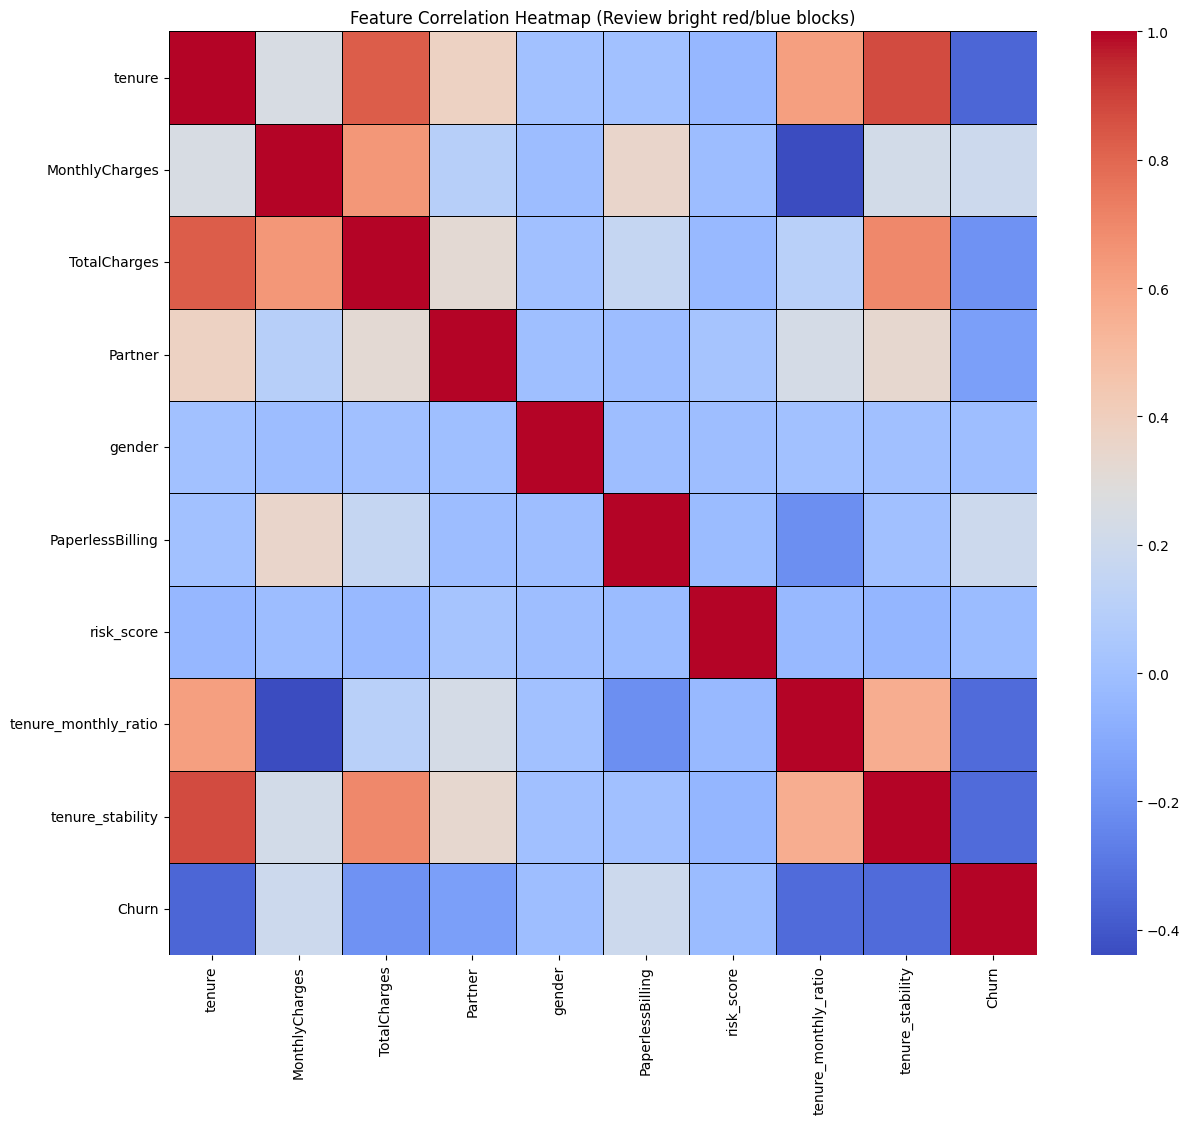

✅ Statistical analysis complete. Review the heatmap for collinearity.


In [6]:
# =============================================================================
# CELL 5: Statistical Feature Analysis (FIXED: Churn drop logic)
# =============================================================================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif

print("\n" + "="*60)
print("FEATURE STATISTICAL ANALYSIS")
print("="*60)

# CRITICAL: We must ensure the RAW 'data' DataFrame is available for this analysis.
# The safest way is to define 'data' by reading the CSV directly.
try:
    # Assuming data_path is available in the environment
    data = pd.read_csv(data_path)

    # Apply the same feature selection as used in the ExperimentRunner
    selected_features = [
        'tenure', 'MonthlyCharges', 'TotalCharges', 'Contract',
        'InternetService', 'Partner', 'gender', 'PaperlessBilling', 'Churn'
    ]
    data = data[selected_features].copy()

except Exception as e:
    print(f"❌ Analysis failed. Could not load RAW data from {data_path}. Error: {e}")
    data = None


if data is not None:
    # Separate features (X) and target (y)
    X_raw = data.drop(columns=['Churn'])
    y = data['Churn'].map({'Yes': 1, 'No': 0})

    try:
        print("\nApplying Preprocessing steps (Cleaner & Engineer ONLY) for analysis...")

        # 1. Initial Data Cleaner
        temp_cleaner = runner.preprocessor.pipeline.named_steps['initial_cleaner']
        X_cleaned = temp_cleaner.transform(X_raw)

        # 2. Feature Engineer (Creates risk_score, etc.)
        temp_engineer = runner.preprocessor.pipeline.named_steps['feature_engineer']
        X_processed = temp_engineer.transform(X_cleaned)

        # Select all numerical features from the engineered DataFrame
        X_mi = X_processed.select_dtypes(include=np.number)

        # --- 1. MUTUAL INFORMATION (MI) ANALYSIS ---
        print("\n--- Mutual Information (MI) Analysis ---")
        # Ensure X_mi contains only features, not the target
        mi_results = mutual_info_classif(X_mi, y.values.ravel(), random_state=42)
        mi_df = pd.Series(mi_results, index=X_mi.columns).sort_values(ascending=False)
        print(mi_df)
        print(f"Interpretation: High MI indicates strong feature relevance to 'Churn'.")

        # --- Prepare data for Variance and Correlation (MUST include 'Churn') ---
        # The key fix is here: we create the final numeric matrix for correlation
        X_numeric = X_mi.copy() # Start with processed numerical features
        X_numeric['Churn'] = y.values # Concatenate the target column directly

        # 2. FEATURE VARIANCE
        print("\n--- Feature Variance Analysis (Top 20) ---")
        # Drop Churn from variance calc to avoid target-variance skewing results
        variance_results = X_numeric.drop(columns=['Churn']).var().sort_values(ascending=False).head(20)
        print(variance_results)

        # 3. CORRELATION MATRIX
        print("\n--- Feature Correlation Analysis ---")

        corr_matrix = X_numeric.corr()
        target_corr = corr_matrix['Churn'].sort_values(ascending=False)
        print("\nCorrelation with Target (Churn):")
        print(target_corr)

        # Plot Heatmap for visualization
        plt.figure(figsize=(14, 12))
        sns.heatmap(corr_matrix,
                    annot=False,
                    cmap='coolwarm',
                    fmt=".2f",
                    linewidths=.5,
                    linecolor='black')
        plt.title('Feature Correlation Heatmap (Review bright red/blue blocks)')
        plt.show()

        print("✅ Statistical analysis complete. Review the heatmap for collinearity.")

    except Exception as e:
        print(f"❌ Analysis failed. Ensure Preprocessor was fitted in Cell 3 and Pipeline structure is correct. Error: {e}")

In [ ]:
# =============================================================================
# CELL 5: Run multiple experiments (specific seeds)
# =============================================================================
print("\n" + "="*60)
print("RUNNING WITH SPECIFIC SEEDS")
print("="*60)

specific_seeds = [42, 101, 202, 303, 404]
specific_results = runner.run_multiple_experiments(
    data_path=data_path,
    seeds=specific_seeds,
    results_path="artifacts/specific_seed_results.csv"
)

if len(specific_results) > 0:
    print("\nSpecific Seeds Results:")
    print(specific_results[['seed', 'Precision', 'Recall', 'F1-Score', 'ROC AUC', 'BusinessCost']])

print("\n✅ All experiments completed successfully!")
print("Results saved to artifacts/ directory")
